# Supervised learning
By Joan Massallé Richart

## Carregar les dades

In [32]:
from scipy.io import arff
import pandas as pd

data, _ = arff.loadarff('../data/MagicTelescope.arff')
df = pd.DataFrame(data)
df.drop(columns=['ID'], inplace=True)
df.head(5)

,fLength:,fWidth:,fSize:,fConc:,fConc1:,fAsym:,fM3Long:,fM3Trans:,fAlpha:,fDist:,class:
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,b'g'
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,b'g'
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,b'g'
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,b'g'
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,b'g'


## Exploratory Data Analysis (EDA)

Com podem veure en el següent gràfic, hi ha un desvalanceig important en les classes a predir, això és important tenir-ho en compte a posteriori quan entrenem el model:

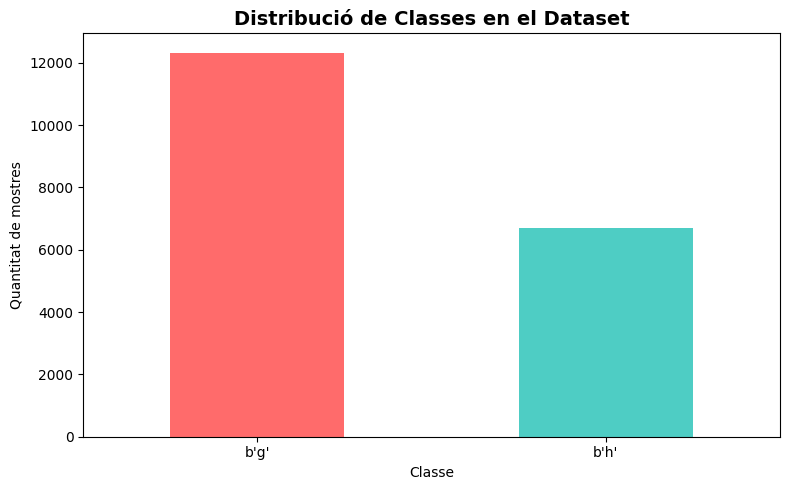

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
df["class:"].value_counts().plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4'])
ax.set_title('Distribució de Classes en el Dataset', fontsize=14, fontweight='bold')
ax.set_xlabel('Classe')
ax.set_ylabel('Quantitat de mostres')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

## Xarxa Neuronal Artificial (ANN)

### Introducció

He decidit utilitzar una Xarxa Neuronal Artificial (ANN) implementada amb PyTorch per aquest problema de classificació binària. Aquesta elecció es basa en diverses consideracions tècniques i pràctiques:

**Per què una ANN?**
- **Capacitat d'aprenentatge no lineal**: Les ANNs poden capturar patrons complexos i relacions no lineals entre les característiques del telescopi, cosa que és crucial per distingir entre raigs gamma i hadrons
- **Flexibilitat arquitectònica**: Podem ajustar fàcilment el nombre de capes ocultes i neurones per optimitzar el rendiment
- **Gestió del desbalanceig**: Mitjançant l'ús de pesos de classe (*class weights*), podem compensar el desbalanceig observat en el dataset
- **Control del procés d'entrenament**: PyTorch ens permet monitoritzar l'evolució de la pèrdua (*loss*) en cada època, implementar *early stopping* i ajustar hiperparàmetres de forma precisa

**Estructura de la xarxa:**
- **Capa d'entrada (*input layer*)**: 11 característiques derivades de les imatges del telescopi
- **Capa oculta (*hidden layer*)**: Nombre configurable de neurones amb funció d'activació ReLU (per defecte 5, però experimentarem amb diferents valors)
- **Capa de sortida (*output layer*)**: 1 neurona amb activació Sigmoid implícita (gestionada per `BCEWithLogitsLoss`) per classificació binària


### Preparació de les dades

Ara necessitem:
1. **Separar les característiques (X)**: Columnes que el model utilitzarà com entrada (totes menys la classe)
2. **Separar l'objectiu (y)**: Columna a predir (la columna `class:`) i codificar-la

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Dades i output
X = df.drop(columns=['class:'])
y = df['class:']

# Codificar els possibles outputs
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

3. **Dividir en entrenament, validació i prova**
    - 60% Entrenament
    - 20% Validació
    - 20% Prova
    - Estratificada per mantenir les proporcions de classes

In [35]:
# Split 80/20% (train+val/test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
# Split 75/25% de temp (train/val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

print("Dades:", X_train.shape, X_val.shape, X_test.shape)
print("Classes:", y_train.shape, y_val.shape, y_test.shape)

Dades: (11412, 10) (3804, 10) (3804, 10)
Classes: (11412,) (3804,) (3804,)


5. **Estandaritzar les dades**: En base al dataset de train s'estandaritzen les altres dos

In [36]:
from sklearn.preprocessing import StandardScaler

# Normalitzar les dades
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train) # Normalitzem train
X_val_scaled = scaler_final.transform(X_val) # Normalitzem val amb els paràmetres de train
X_test_scaled = scaler_final.transform(X_test) # Normalitzem test amb els paràmetres de train

6. **Convertir les dades a tensors de torch** per poder pasar-les al model

In [37]:
import torch

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

7. **Calcular els pesos de cada classe** per penalitzar més al model en les classes minoritàries 

In [38]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular els pesos de cada classe per evitar desbalanceig
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
pos_weight = torch.tensor(class_weights[1] / class_weights[0], dtype=torch.float32)

for class_label, weight in class_weight_dict.items():
    print(f"  Clase {class_label}: {weight:.4f}")

  Clase 0: 0.7711
  Clase 1: 1.4222


## Entrenament de la ANN

En aquesta secció implementarem i entrenarem la nostra xarxa neuronal. El procés inclou:
1. Definir l'arquitectura del model
2. Implementar funcions d'entrenament i visualització
3. Entrenar el model i analitzar la seva evolució
4. Estudiar l'efecte dels hiperparàmetres (complexitat i mida de mostra)

### Arquitectura

La nostra arquitectura `SimpleANN` és una xarxa *feedforward* amb:
- **Input**: 11 característiques normalitzades
- **Capa oculta**: Nombre configurable de neurones amb ReLU
- **Output**: 1 neurona (logit) per classificació binària

Utilitzem `BCEWithLogitsLoss` que aplica internament la funció Sigmoid, millorant l'estabilitat numèrica.

In [39]:
import torch
import torch.nn as nn

class SimpleANN(nn.Module):
    def __init__(self, input_dim, hidden_size=5):
        super(SimpleANN, self).__init__()
        # Capa oculta: fully connected
        self.fc1 = nn.Linear(input_dim, hidden_size)  # 5 neuronas en la capa oculta
        # Capa de salida: fully connected
        self.fc2 = nn.Linear(hidden_size, 1)          # 1 neurona para salida binaria

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)   # SIN sigmoid porque ya lo hace el criterion
        return x

### Implementació de funcions

Implementem tres funcions auxiliars:
- `train_model()`: Entrena el model amb suport per *early stopping*
- `plot_training_history()`: Visualitza l'evolució de la pèrdua
- `plot_accuracy()`: Grafica l'accuracy vs hiperparàmetre

In [40]:
def train_model(
        model, criterion, optimizer, X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor, epochs=1000, patience=None, print_progress=True
    ):

    losses = {'train': [], 'val': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Entrenament
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses['train'].append(loss.item())
        
        # Validació
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            losses['val'].append(val_loss.item())
        
        # Early stopping (if patience)
        if patience is not None:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else: patience_counter += 1
            
            if patience_counter >= patience:
                if print_progress: print(f"Early stopping at epoch {epoch}")
                break
        
        if (epoch % (epochs // 10) == 0 or epoch == epochs - 1) and print_progress:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    return losses

In [41]:
import matplotlib.pyplot as plt

def plot_training_history(losses_dict, show_best_epoch=False):
    if show_best_epoch:
        pos = losses_dict['val'].index(min(losses_dict['val']))
        print(f"Best epoch: {pos}, Train Loss: {losses_dict['train'][pos]:.4f}, Val Loss: {losses_dict['val'][pos]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(losses_dict['train'], label='Train Loss', linewidth=2)
    plt.plot(losses_dict['val'], label='Validation Loss', linewidth=2)
    
    if show_best_epoch:
        plt.axvline(x=pos, color='red', linestyle='--', linewidth=2, label='Best Epoch')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Training and Validation Loss Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [42]:
def plot_accuracy(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['hidden_size'], df['train_accuracy'], marker='o', label='Train')
    plt.plot(df['hidden_size'], df['test_accuracy'], marker='o', label='Test')
    plt.xscale('log', base=2)
    plt.xlabel('hidden_size')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs hidden_size')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

### Evolució de l'accuracy del model

Primer entrenem un model sense *early stopping* per observar com evoluciona la pèrdua durant moltes èpoques. Això ens permetrà identificar el punt òptim d'entrenament i detectar possibles signes de sobreajust.

Epoch 0, Train Loss: 0.9362, Val Loss: 0.9366
Epoch 10000, Train Loss: 0.4513, Val Loss: 0.4858
Epoch 20000, Train Loss: 0.4513, Val Loss: 0.4858
Epoch 30000, Train Loss: 0.4513, Val Loss: 0.4858
Epoch 40000, Train Loss: 0.4513, Val Loss: 0.4858
Epoch 50000, Train Loss: 0.4513, Val Loss: 0.4858
Epoch 60000, Train Loss: 0.4513, Val Loss: 0.4858
Epoch 70000, Train Loss: 0.4513, Val Loss: 0.4858
Epoch 80000, Train Loss: 0.4513, Val Loss: 0.4858
Epoch 90000, Train Loss: 0.4513, Val Loss: 0.4858
Epoch 99999, Train Loss: 0.4513, Val Loss: 0.4858
Best epoch: 8137, Train Loss: 0.4513, Val Loss: 0.4857


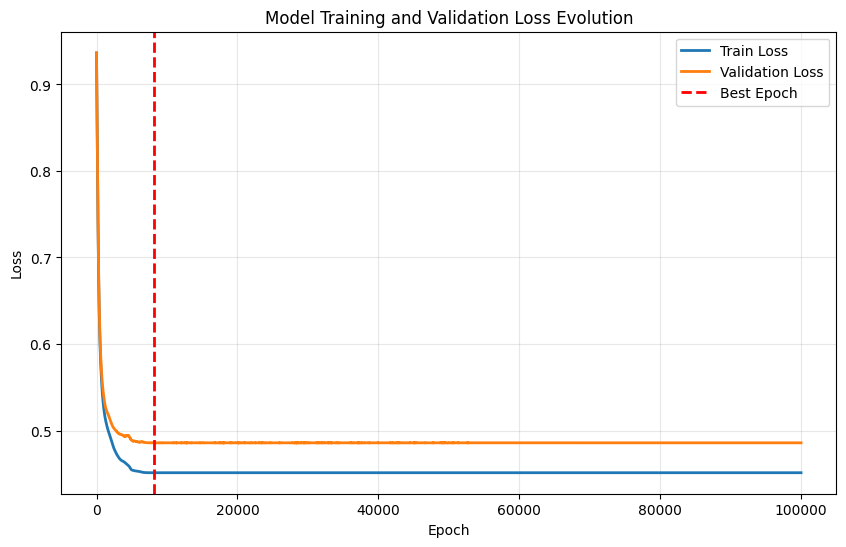

In [43]:
trainest_model = SimpleANN(input_dim = X_train_scaled.shape[1])

train_losses_dict = train_model(
    model = trainest_model,
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight),
    optimizer = torch.optim.Adam(trainest_model.parameters(), lr=0.001),
    X_train_tensor = X_train_tensor,
    y_train_tensor = y_train_tensor,
    X_val_tensor = X_val_tensor,
    y_val_tensor = y_val_tensor,
    epochs=100000
)

plot_training_history(train_losses_dict, show_best_epoch=True)

### Testeig de la paciència del model

L'*early stopping* és una tècnica de regularització que atura l'entrenament quan la pèrdua de validació deixa de millorar. Amb un `patience=50`, el model s'atura si no millora durant 50 èpoques consecutives.

El paràmetre paciència sembla funcionar correctament:

In [44]:
impatient_model = SimpleANN(input_dim = X_train_scaled.shape[1])

train_losses_dict = train_model(
    model = impatient_model,
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight),
    optimizer = torch.optim.Adam(impatient_model.parameters(), lr=0.001),
    X_train_tensor = X_train_tensor,
    y_train_tensor = y_train_tensor,
    X_val_tensor = X_val_tensor,
    y_val_tensor = y_val_tensor,
    epochs=100000,
    patience=50
)

Epoch 0, Train Loss: 0.8929, Val Loss: 0.8911
Early stopping at epoch 3461


### Evolució de la complexitat del model

**Anàlisi de complexitat (Complexity Analysis)**

Estudiem l'efecte del nombre de neurones a la capa oculta (`hidden_size`) sobre el rendiment del model. Aquest hiperparàmetre controla la capacitat del model:
- **Valors baixos** (4-16): Risc de *underfitting* - el model no té prou capacitat per aprendre els patrons
- **Valors alts** (512-2048): Risc de *overfitting* - el model memoritza les dades d'entrenament

Esperem veure que l'accuracy de train augmenta amb la complexitat, mentre que l'accuracy de test arribarà a un màxim i després pot decréixer.

Hidden Size: 4, Train Accuracy: 0.8245, Test Accuracy: 0.8323
Hidden Size: 8, Train Accuracy: 0.8401, Test Accuracy: 0.8504
Hidden Size: 16, Train Accuracy: 0.8510, Test Accuracy: 0.8554
Hidden Size: 32, Train Accuracy: 0.8598, Test Accuracy: 0.8623
Hidden Size: 64, Train Accuracy: 0.8641, Test Accuracy: 0.8680
Hidden Size: 128, Train Accuracy: 0.8711, Test Accuracy: 0.8699
Hidden Size: 256, Train Accuracy: 0.8776, Test Accuracy: 0.8678
Hidden Size: 512, Train Accuracy: 0.8867, Test Accuracy: 0.8707
Hidden Size: 1024, Train Accuracy: 0.8886, Test Accuracy: 0.8720
Hidden Size: 2048, Train Accuracy: 0.8915, Test Accuracy: 0.8743


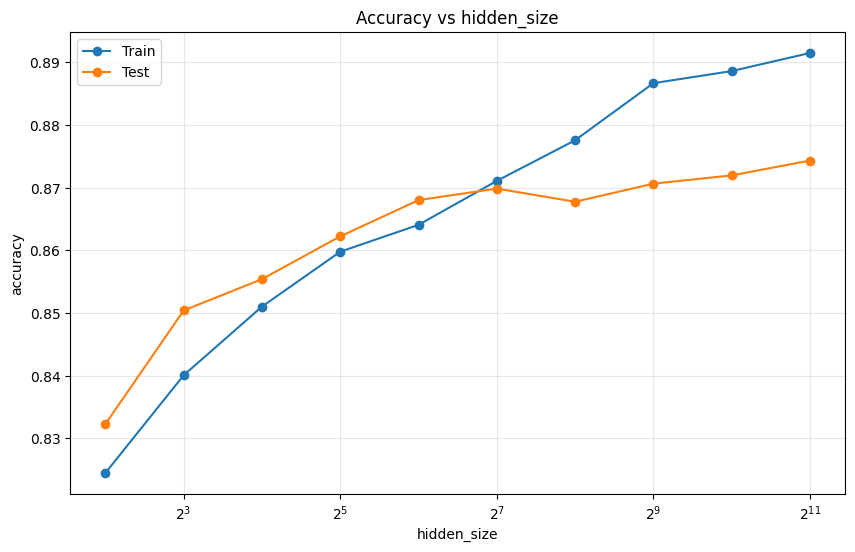

In [45]:
complexity_sizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

accuracy_results = []

for hidden_size in complexity_sizes:
    custom_model = SimpleANN(input_dim = X_train_scaled.shape[1], hidden_size=hidden_size)

    train_losses_dict = train_model(
        model = custom_model,
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight),
        optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001),
        X_train_tensor = X_train_tensor,
        y_train_tensor = y_train_tensor,
        X_val_tensor = X_val_tensor,
        y_val_tensor = y_val_tensor,
        epochs=1000,
        patience=50,
        print_progress=False
    )

    custom_model.eval()
    with torch.no_grad():
        train_logits = custom_model(X_train_tensor)
        train_probs = torch.sigmoid(train_logits)
        train_preds = (train_probs > 0.5).float()
        train_acc = (train_preds == y_train_tensor).float().mean().item()

        test_logits = custom_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > 0.5).float()
        test_acc = (test_preds == y_test_tensor).float().mean().item()

    accuracy_results.append({
        'hidden_size': hidden_size,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })
    print(f"Hidden Size: {hidden_size}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

plot_accuracy(pd.DataFrame(accuracy_results))

### Evolució del Model en base al sample_size

**Corbes d'aprenentatge (Learning Curves)**

Analitzem com varia el rendiment en funció de la quantitat de dades d'entrenament. Entrenem amb subconjunts creixents del 5% al 100% de les dades.

Esperem observar:
- **Amb poques dades**: Alta accuracy en train (fàcil de memoritzar), baixa accuracy en test
- **Amb més dades**: Les corbes convergeixen cap a un valor estable
- Si les corbes no convergeixen, indica que el model es beneficiaria de més dades

Sample Size: 0.05, Train Accuracy: 0.8825, Test Accuracy: 0.8486
Sample Size: 0.1, Train Accuracy: 0.8703, Test Accuracy: 0.8504
Sample Size: 0.2, Train Accuracy: 0.8637, Test Accuracy: 0.8591
Sample Size: 0.3, Train Accuracy: 0.8712, Test Accuracy: 0.8601
Sample Size: 0.4, Train Accuracy: 0.8652, Test Accuracy: 0.8594
Sample Size: 0.5, Train Accuracy: 0.8691, Test Accuracy: 0.8623
Sample Size: 0.6, Train Accuracy: 0.8661, Test Accuracy: 0.8654
Sample Size: 0.7, Train Accuracy: 0.8617, Test Accuracy: 0.8654
Sample Size: 0.8, Train Accuracy: 0.8637, Test Accuracy: 0.8699
Sample Size: 0.9, Train Accuracy: 0.8629, Test Accuracy: 0.8638
Sample Size: 1.0, Train Accuracy: 0.8637, Test Accuracy: 0.8657


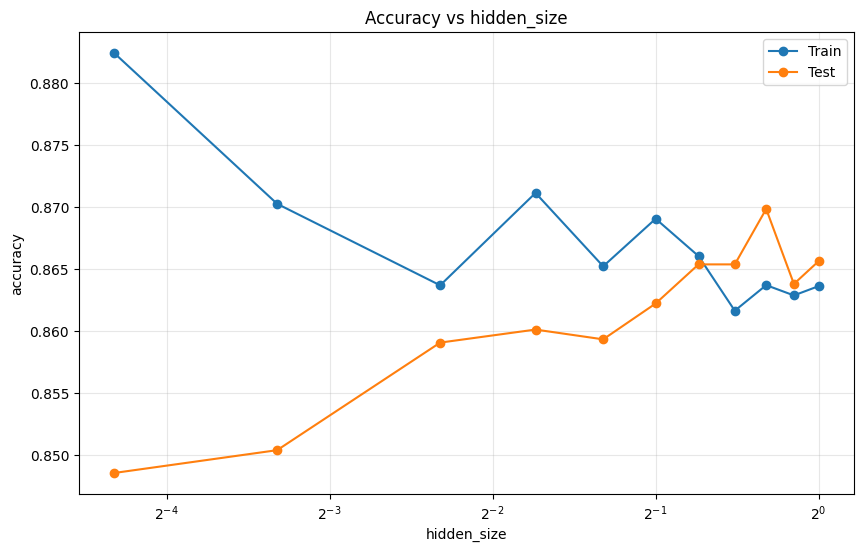

In [46]:
sample_sizes = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]
sample_results = []

for size_fraction in sample_sizes:
    n_samples = int(len(X_train_tensor) * size_fraction)
    indices = torch.randperm(len(X_train_tensor))[:n_samples]
    X_train_subset = X_train_tensor[indices]
    y_train_subset = y_train_tensor[indices]

    custom_model = SimpleANN(input_dim = X_train_scaled.shape[1], hidden_size=64)

    train_losses_dict = train_model(
        model = custom_model,
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight),
        optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001),
        X_train_tensor = X_train_subset,
        y_train_tensor = y_train_subset,
        X_val_tensor = X_val_tensor,
        y_val_tensor = y_val_tensor,
        epochs=1000,
        patience=50,
        print_progress=False
    )

    custom_model.eval()
    with torch.no_grad():
        train_logits = custom_model(X_train_subset)
        train_probs = torch.sigmoid(train_logits)
        train_preds = (train_probs > 0.5).float()
        train_acc = (train_preds == y_train_subset).float().mean().item()

        test_logits = custom_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > 0.5).float()
        test_acc = (test_preds == y_test_tensor).float().mean().item()

    sample_results.append({
        'sample_size': size_fraction,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })
    print(f"Sample Size: {size_fraction}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    
sample_results_df = pd.DataFrame(sample_results)
plot_accuracy(sample_results_df.rename(columns={'sample_size': 'hidden_size'}))

### Implementació del model final

Basant-nos en l'anàlisi de complexitat, seleccionem el `hidden_size` òptim i entrenem el model final amb *early stopping* per evitar sobreajust.

In [47]:
# Model final amb hidden_size òptim (basat en l'anàlisi anterior)
model = SimpleANN(input_dim=X_train_scaled.shape[1], hidden_size=64)

# Entrenar amb early stopping
final_losses = train_model(
    model=model,
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,
    y_val_tensor=y_val_tensor,
    epochs=10000,
    patience=50,
    print_progress=True
)

Epoch 0, Train Loss: 0.9580, Val Loss: 0.9514
Epoch 1000, Train Loss: 0.4437, Val Loss: 0.4771
Epoch 2000, Train Loss: 0.4039, Val Loss: 0.4590
Early stopping at epoch 2617


### Evaluació del model final

Avaluem el model final amb múltiples mètriques sobre el conjunt de test (que mai s'ha utilitzat durant l'entrenament):
- **Accuracy**: Proporció de prediccions correctes
- **Precision**: De les prediccions positives, quantes són correctes
- **Recall**: De tots els positius reals, quants hem detectat
- **F1-Score**: Mitjana harmònica de precision i recall
- **ROC-AUC**: Àrea sota la corba ROC (capacitat de discriminació)
- **Matriu de confusió**: Visualització dels errors per classe

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

model.eval()

with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits)
    predictions = (probs > 0.5).float()

# Convertir predictions i ground truth a numpy arrays
y_pred = predictions.numpy().flatten()
y_true = y_test_tensor.numpy().flatten()

# Calcular mètriques
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, probs.numpy().flatten())
cm = confusion_matrix(y_true, y_pred)

# Mostrar resultats
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")

Accuracy:  0.8686
Precision: 0.8045
Recall:    0.8274
F1-Score:  0.8158
ROC-AUC:   0.9357

Confusion Matrix:
[[2197  269]
 [ 231 1107]]


## Aprenentatge Semi-Supervisat (SSL)

### Introducció al Semi-Supervised Learning (SSL)

**Tècnica utilitzada: Pseudo-labeling**

Implementarem *pseudo-labeling*, una tècnica simple però efectiva:
1. Entrenem el model inicialment amb les dades etiquetades
2. Utilitzem el model per predir etiquetes per les dades no etiquetades
3. Seleccionarem les prediccions d'alta confiança (>90%) com a *pseudo-etiquetes*
4. Reentrenarem el model incloent aquestes pseudo-etiquetes

**Experiment**

Analitzarem com varia el rendiment del model en funció de:
- **Quantitat de dades etiquetades**: 30, 300, 3000 mostres
- **Quantitat de dades no etiquetades**: de 10 a 10.000 mostres

L'objectiu és observar si les dades no etiquetades milloren el rendiment, especialment quan tenim poques dades etiquetades.

### Preparació de les dades semi-supervisades

Primer, necessitem una funció per **simular un escenari semi-supervisat**: agafem el dataset complet i "amaguem" les etiquetes d'una part de les dades (les convertim a NaN).

Això ens permet controlar exactament quantes dades etiquetades i no etiquetades tenim.

In [49]:
from sklearn.model_selection import train_test_split

def make_unlabeled_random_strafied(data, iclass, proportion, random_state=42):
    if not (0 < proportion <= 1):
        raise ValueError("La proporció de mostres etiquetades ha de ser un float entre 0 i 1.")
    
    # Dividim el dataset en subconjunts etiquetats i no etiquetats
    # Utilitzem estratificació per mantenir la proporció de classes
    labeled_data, unlabeled_data = train_test_split(
        data,
        stratify=data.iloc[:,iclass],
        train_size=proportion,
        random_state=random_state
    )
    
    # Amaguem les etiquetes del subconjunt no etiquetat (les convertim a NaN)
    unlabeled_data = unlabeled_data.copy()
    unlabeled_data = unlabeled_data.astype({unlabeled_data.columns[iclass]: float})
    unlabeled_data.iloc[:,iclass] = np.nan
    
    # Combinem els dos subconjunts
    ss_data = pd.concat([labeled_data, unlabeled_data]).sort_index()

    return ss_data

### Funció d'entrenament semi-supervisat

Aquesta funció implementa el **pseudo-labeling** durant l'entrenament:

1. **Pas 1**: Entrenem amb dades etiquetades (com un model supervisat normal)
2. **Pas 2**: Generem prediccions per les dades no etiquetades
3. **Pas 3**: Filtrem només les prediccions amb alta confiança (>threshold)
4. **Pas 4**: Reentrenem amb les pseudo-etiquetes seleccionades

El paràmetre `confidence_threshold` (per defecte 0.9) controla quantes pseudo-etiquetes acceptem. Un valor alt significa que només acceptem prediccions molt segures.

In [50]:
def train_model_semisupervised(
        model, criterion, optimizer,
        X_labeled, y_labeled,
        X_val, y_val,
        X_unlabeled=None,
        epochs=1000, patience=None,
        confidence_threshold=0.9,
        print_progress=True
    ):

    losses = {'train': [], 'val': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Entrenament amb dades etiquetades
        model.train()
        outputs = model(X_labeled)
        loss_labeled = criterion(outputs, y_labeled)
        
        optimizer.zero_grad()
        loss_labeled.backward()
        optimizer.step()
        
        train_loss = loss_labeled.item()
        n_pseudo = 0  # Comptador de pseudo-etiquetes utilitzades
        
        # Generació i ús de pseudo-etiquetes
        if X_unlabeled is not None and len(X_unlabeled) > 0:
            model.eval()
            with torch.no_grad():
                # Prediem probabilitats per les dades no etiquetades
                unlabeled_logits = model(X_unlabeled)
                probs = torch.sigmoid(unlabeled_logits)
                
                # Només acceptem prediccions amb alta confiança
                mask_high_conf = (probs > confidence_threshold) | (probs < 1 - confidence_threshold)
                mask_high_conf = mask_high_conf.squeeze()
                
                # Gestió del cas d'un sol element
                if mask_high_conf.dim() == 0:
                    mask_high_conf = mask_high_conf.unsqueeze(0)
                
                # Creem pseudo-etiquetes per les mostres d'alta confiança
                X_pseudo = X_unlabeled[mask_high_conf]
                y_pseudo = (probs[mask_high_conf] > 0.5).float().reshape(-1, 1)
                n_pseudo = len(X_pseudo)
            
            # Entrenem amb les pseudo-etiquetes si n'hi ha
            if n_pseudo > 0:
                model.train()
                outputs_pseudo = model(X_pseudo)
                loss_pseudo = criterion(outputs_pseudo, y_pseudo)
                
                optimizer.zero_grad()
                loss_pseudo.backward()
                optimizer.step()
                
                # Ponderem la pèrdua segons la proporció de dades
                alpha = len(X_labeled) / (len(X_labeled) + n_pseudo)
                train_loss = alpha * train_loss + (1 - alpha) * loss_pseudo.item()
                
        losses['train'].append(train_loss)
        
        # Validació
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            losses['val'].append(val_loss.item())
        
        # Early stopping
        if patience is not None:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if print_progress:
                    print(f"Early stopping a l'època {epoch}")
                break
        
        # Impressió de progrés
        if (epoch % max(1, (epochs // 10)) == 0 or epoch == epochs - 1) and print_progress:
            print(f"Època {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, Pseudo-etiquetes: {n_pseudo}")
    
    return losses

### Funció per extreure subconjunts de dades

Per experimentar amb diferents quantitats de dades etiquetades i no etiquetades, necessitem una funció que:
1. Extregui `n_labeled` mostres etiquetades
2. Extregui `n_unlabeled` mostres no etiquetades
3. **Normalitzi les dades** utilitzant l'escalador ajustat amb les dades etiquetades

In [51]:
from sklearn.preprocessing import StandardScaler

def get_subset_data(ss_data, n_labeled, n_unlabeled, target_col='target', random_state=42):
    # Subconjunt etiquetat
    labeled_data = ss_data[ss_data[target_col].notna()]
    labeled_subset = labeled_data.sample(n=min(n_labeled, len(labeled_data)), random_state=random_state)
    
    # Subconjunt no etiquetat
    unlabeled_data = ss_data[ss_data[target_col].isna()]
    unlabeled_subset = unlabeled_data.sample(n=min(n_unlabeled, len(unlabeled_data)), random_state=random_state)
    
    # Separar característiques i etiquetes
    X_labeled_raw = labeled_subset.drop(columns=[target_col]).values
    y_labeled = labeled_subset[target_col].values
    X_unlabeled_raw = unlabeled_subset.drop(columns=[target_col]).values
    
    # Normalitzar les dades utilitzant l'escalador ajustat amb les dades etiquetades
    scaler = StandardScaler()
    X_labeled_scaled = scaler.fit_transform(X_labeled_raw)
    X_unlabeled_scaled = scaler.transform(X_unlabeled_raw) if len(X_unlabeled_raw) > 0 else X_unlabeled_raw
    
    # Convertir a tensors de PyTorch
    X_labeled = torch.tensor(X_labeled_scaled, dtype=torch.float32)
    y_labeled = torch.tensor(y_labeled, dtype=torch.float32).reshape(-1, 1)
    X_unlabeled = torch.tensor(X_unlabeled_scaled, dtype=torch.float32)
    
    return X_labeled, y_labeled, X_unlabeled, scaler

In [52]:
def compute_accuracy(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        logits = model(X_val)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        correct = (preds == y_val).sum().item()
        total = y_val.size(0)
        return correct / total

### Experiment: Impacte de les dades no etiquetades

Ara executem l'experiment principal on:
1. **Creem el dataset semi-supervisat** amb un 20% de dades etiquetades
2. **Per cada combinació** de (n_labeled, n_unlabeled):
   - Extraiem subconjunts de dades
   - Entrenem un model nou amb pseudo-labeling
   - Avaluem sobre un conjunt de test global
3. **Visualitzem els resultats** per veure si les dades no etiquetades ajuden

**Variables de l'experiment:**
- `labeled_sizes`: [30, 300, 3000] mostres etiquetades
- `unlabeled_sizes`: [10, 100, 500, 1000, 5000, 10000] mostres no etiquetades

Creem el dataset semi-supervisat utilitzant la funció `make_unlabeled_random_strafied`. Mantenim un 20% de les dades etiquetades i "amaguem" les etiquetes del 80% restant.

In [53]:
# Preparar el dataset per SSL
df_ssl = df.copy()
df_ssl['target'] = label_encoder.transform(df_ssl['class:'])
df_ssl = df_ssl.drop(columns=['class:'])

# Crear dataset semi-supervisat (20% etiquetat, 80% no etiquetat)
ss_data = make_unlabeled_random_strafied(
    df_ssl, 
    iclass=df_ssl.columns.get_loc('target'), 
    proportion=0.2, 
    random_state=42
)


=== Etiquetados: 30, No etiquetados: 10 ===
    Test Accuracy: 0.7543

=== Etiquetados: 30, No etiquetados: 100 ===
    Test Accuracy: 0.7083

=== Etiquetados: 30, No etiquetados: 500 ===
    Test Accuracy: 0.6951

=== Etiquetados: 30, No etiquetados: 1000 ===
    Test Accuracy: 0.7240

=== Etiquetados: 30, No etiquetados: 5000 ===
    Test Accuracy: 0.7385

=== Etiquetados: 30, No etiquetados: 10000 ===
    Test Accuracy: 0.6846

=== Etiquetados: 300, No etiquetados: 10 ===
    Test Accuracy: 0.8121

=== Etiquetados: 300, No etiquetados: 100 ===
    Test Accuracy: 0.8081

=== Etiquetados: 300, No etiquetados: 500 ===
    Test Accuracy: 0.7976

=== Etiquetados: 300, No etiquetados: 1000 ===
    Test Accuracy: 0.8147

=== Etiquetados: 300, No etiquetados: 5000 ===
    Test Accuracy: 0.8160

=== Etiquetados: 300, No etiquetados: 10000 ===
    Test Accuracy: 0.8318

=== Etiquetados: 3000, No etiquetados: 10 ===
    Test Accuracy: 0.8489

=== Etiquetados: 3000, No etiquetados: 100 ===
   

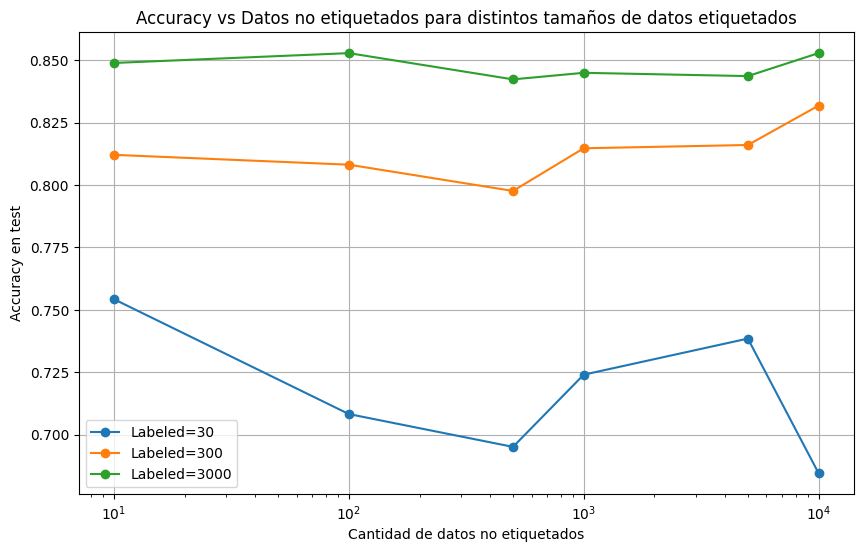

In [54]:
from sklearn.utils.class_weight import compute_class_weight

results = {}

labeled_sizes = [30, 300, 3000]
unlabeled_sizes = [10, 100, 500, 1000, 5000, 10000]
accuracies = {n_labeled: [] for n_labeled in labeled_sizes}

# Preparar conjunto de test global (normalizado con scaler global)
# Lo usaremos para evaluar todos los modelos de forma consistente
test_data = ss_data[ss_data['target'].notna()].sample(frac=0.2, random_state=123)
X_test_global = test_data.drop(columns=['target']).values
y_test_global = test_data['target'].values

for n_labeled in labeled_sizes:
    for n_unlabeled in unlabeled_sizes:
        # Extraer subconjuntos (ahora devuelve scaler)
        X_l, y_l, X_u, scaler = get_subset_data(ss_data, n_labeled, n_unlabeled, target_col='target')
        
        # Para conjuntos pequeños, usar más datos para entrenamiento
        val_size = 0.2 if n_labeled >= 50 else 0.1
        min_val_samples = max(2, int(n_labeled * val_size))
        
        # Asegurar que tenemos suficientes muestras para estratificar
        y_flat = y_l.numpy().flatten()
        unique, counts = np.unique(y_flat, return_counts=True)
        can_stratify = all(c >= 2 for c in counts)
        
        if can_stratify and len(y_flat) >= 10:
            X_train, X_val, y_train, y_val = train_test_split(
                X_l.numpy(), y_flat, test_size=val_size, stratify=y_flat, random_state=42
            )
        else:
            # Sin estratificación para conjuntos muy pequeños
            X_train, X_val, y_train, y_val = train_test_split(
                X_l.numpy(), y_flat, test_size=val_size, random_state=42
            )
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
        
        # Calcular pos_weight dinámicamente para este subconjunto
        y_train_int = y_train.astype(int)
        if len(np.unique(y_train_int)) > 1:
            class_weights_local = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
            pos_weight_local = torch.tensor(class_weights_local[1] / class_weights_local[0], dtype=torch.float32)
        else:
            pos_weight_local = torch.tensor(1.0, dtype=torch.float32)
        
        # Modelo fresh
        model = SimpleANN(input_dim=X_train_tensor.shape[1], hidden_size=64)
        
        # Entrenar
        print(f"\n=== Etiquetados: {n_labeled}, No etiquetados: {n_unlabeled} ===")
        losses = train_model_semisupervised(
            model=model,
            criterion=torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_local),
            optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
            X_labeled=X_train_tensor,
            y_labeled=y_train_tensor,
            X_val=X_val_tensor,
            y_val=y_val_tensor,
            X_unlabeled=X_u,
            epochs=1000,
            patience=50,
            confidence_threshold=0.9,
            print_progress=False
        )
        
        # Evaluar en test global (normalizado con el mismo scaler)
        X_test_scaled = scaler.transform(X_test_global)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_global, dtype=torch.float32).reshape(-1, 1)
        
        # Guardar resultados
        results[(n_labeled, n_unlabeled)] = losses
        acc = compute_accuracy(model, X_test_tensor, y_test_tensor)
        accuracies[n_labeled].append(acc)
        print(f"    Test Accuracy: {acc:.4f}")

# Graficar
plt.figure(figsize=(10,6))
for n_labeled in labeled_sizes:
    plt.plot(unlabeled_sizes, accuracies[n_labeled], marker='o', label=f"Labeled={n_labeled}")

plt.xscale('log')
plt.xlabel("Cantidad de datos no etiquetados")
plt.ylabel("Accuracy en test")
plt.title("Accuracy vs Datos no etiquetados para distintos tamaños de datos etiquetados")
plt.legend()
plt.grid(True)
plt.show()

Part del codi d'aquest notebook ha sigut generat gràcies a Github Copilot. Sóc entenedor de tot el codi escrit fins a certa profunditat (codi intern de llibreries, etc)